In [1]:
# Importação das bibliotecas utilizadas no trabalho.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import seaborn as sns
import shutil
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, balanced_accuracy_score, get_scorer_names
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Montando o acesso ao Google Drive na máquina do Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Copiando os arquivos do meu Google Drive para a máquina do Colab.
! cp /content/drive/MyDrive/inf0619_trabalho_final/features/convnextXLarge_val.parquet /content/
! cp /content/drive/MyDrive/inf0619_trabalho_final/features/convnextXLarge_train.parquet /content/
! cp /content/drive/MyDrive/inf0619_trabalho_final/features/convnextXLarge_test_patient.parquet /content/

In [4]:
# Leitura do conjunto de features, do dataset de treinamento, que foram extraídas da rede convneXtXlarge.
train_features = pd.read_parquet("/content/convnextXLarge_train.parquet")
train_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label
0,0.782490,0.096954,0.262080,0.174282,-0.383177,0.104748,0.793320,0.775638,-0.223562,-0.396620,...,-0.317172,-0.119336,0.818237,0.200412,-0.663302,-0.748892,-0.571000,1.043246,0.003858,0
1,0.467280,0.101803,0.288125,0.040087,-0.410418,-0.237152,0.341802,0.433974,-0.192482,0.037039,...,-0.266931,-0.290033,0.212844,0.351380,-0.399469,-0.499037,-0.221880,0.537133,0.417149,0
2,0.563512,0.124270,0.226611,-0.317395,-0.197211,-0.133061,0.081092,0.485044,-0.144118,0.179420,...,-0.046226,0.087496,0.694079,-0.119628,-0.022707,-0.252247,0.190731,0.298398,-0.074016,0
3,0.383937,0.133545,0.356170,0.253072,-0.400867,0.311865,0.506546,0.474224,-0.158302,-0.186319,...,-0.432675,-0.232704,0.153082,0.503808,-0.302560,-0.505552,-0.094205,0.752288,0.403607,0
4,0.539969,0.056070,0.322341,0.298526,-0.480753,0.181412,0.406155,0.609025,-0.085398,-0.393190,...,-0.245263,-0.200124,0.673855,0.247383,-0.650726,-0.496275,-0.265739,0.853555,0.260939,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35042,0.722012,0.042699,0.231991,-0.113181,-0.224732,0.285437,0.714974,0.477097,-0.136725,-0.361651,...,-0.293015,0.138114,1.075602,0.371254,-0.496169,-0.480217,-0.472666,1.221435,-0.078261,0
35043,0.346065,0.004064,0.327129,0.046828,-0.418746,-0.046233,0.164071,0.316719,-0.122912,-0.151308,...,-0.263095,-0.154106,0.457960,0.195209,-0.304282,-0.428850,-0.348681,1.173619,0.139302,0
35044,0.625576,0.118291,0.466354,-0.180872,-0.424132,0.363793,0.622168,0.332305,-0.072464,-0.151749,...,-0.207177,-0.180458,0.559305,-0.098789,-0.488502,-0.570178,0.593500,0.914358,-0.163439,0
35045,0.488206,0.091432,0.250394,-0.064005,-0.341453,0.255575,0.530682,0.545281,-0.220475,-0.172525,...,-0.132825,-0.355615,0.414869,0.194000,-0.731557,-0.567873,0.336933,0.360110,0.007725,0


In [5]:
# Leitura do conjunto de features, do dataset de validação, que foram extraídas da rede convneXtXlarge.
validation_features =pd.read_parquet("/content/convnextXLarge_val.parquet")
validation_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label
0,0.321539,-0.040745,0.428116,-0.059310,-0.133182,0.175785,0.591816,0.306358,-0.328405,0.046211,...,-0.424844,0.040012,0.586366,0.635589,-0.076856,-0.437887,-0.465474,1.808983,0.126085,0
1,0.863328,0.109210,0.181452,-0.085717,-0.551607,0.085090,1.017017,0.784318,-0.169223,-0.233436,...,-0.302629,-0.072603,0.252117,0.107895,-0.716553,-0.464415,-0.210476,0.532940,0.215660,0
2,0.621498,0.046494,0.217638,0.145566,-0.485521,0.327986,0.750339,0.611870,-0.171179,-0.328355,...,-0.366927,-0.123831,0.744125,0.057504,-0.457560,-0.575832,-0.753164,1.621300,0.161117,0
3,0.506821,0.039643,0.293630,0.082756,-0.610796,0.257617,0.502576,0.563442,-0.172584,-0.004929,...,-0.184850,-0.212367,0.742930,0.269302,-0.607481,-0.517907,0.032292,1.026711,-0.079377,0
4,0.343853,0.142178,0.240785,-0.037477,-0.291627,0.154225,0.494200,0.634773,-0.230634,-0.193642,...,-0.209280,-0.270954,-0.044520,-0.142486,-0.645625,-0.579330,0.050568,0.474704,0.272606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8744,0.611580,0.176106,0.166006,-0.016327,-0.383235,-0.096023,0.574808,0.675598,-0.176140,-0.290138,...,-0.139385,-0.120450,0.237770,0.236707,-0.268464,-0.461777,-0.557336,0.491386,-0.034084,0
8745,0.683683,0.120825,0.093502,0.078464,-0.406492,-0.034391,0.704150,0.753817,-0.197076,-0.182104,...,-0.368558,0.000458,0.417836,0.044448,-0.347991,-0.409663,-0.511226,0.626749,0.208214,0
8746,0.396443,0.082155,0.226763,-0.363815,-0.513668,0.275729,1.005085,0.886076,-0.193303,-0.109343,...,-0.359865,-0.161590,0.858085,0.043154,-0.619210,-0.665731,-0.065258,0.156513,-0.181718,0
8747,0.338843,0.079850,0.308706,0.071187,-0.347819,0.183485,0.395378,0.292172,-0.128342,-0.051909,...,-0.307717,-0.260249,0.455521,0.593497,-0.247874,-0.395693,-0.606585,1.424962,0.210196,0


In [6]:
# Leitura do conjunto de features, do dataset de teste, que foram extraídas da rede convneXtXlarge.
test_features = pd.read_parquet("/content/convnextXLarge_test_patient.parquet")
test_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label,image_id
0,0.286125,0.077281,0.267690,-0.125403,-0.687328,-0.132657,0.668090,0.402662,-0.041012,0.106530,...,-0.091259,0.424867,0.104299,-0.351052,-0.481592,-0.666510,-0.100360,-0.191770,0,0/1000066573.png
1,-0.305934,0.140496,0.391718,-0.064438,-0.265048,0.048315,0.344041,0.107235,-0.299967,0.104992,...,-0.076161,0.204854,-0.019851,-0.055830,-0.471144,-0.297103,0.373199,0.368893,0,0/1000108611.png
2,0.921715,0.062716,0.244886,-0.112345,-0.397146,0.180339,0.535863,0.552860,-0.193361,-0.221842,...,-0.279156,0.578675,0.097681,-0.606028,-0.477128,-0.356049,0.994484,0.022545,0,0/1000203906.png
3,0.785796,0.152850,0.236910,-0.368685,-0.155804,0.472846,0.628691,0.404735,-0.282790,-0.181130,...,-0.420171,0.404125,0.118087,-0.615040,-0.637877,0.380481,0.518340,-0.085029,0,0/1000258681.png
4,0.035032,0.120664,0.374342,-0.132364,-0.413670,0.310536,0.228358,0.243928,-0.168072,-0.102217,...,-0.323548,0.116086,-0.324835,-0.451384,-0.612161,0.610117,0.328234,0.068671,0,0/1000302588.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,0.485129,0.181815,0.272408,0.262057,-0.343794,0.205493,0.535985,0.630040,-0.118662,-0.279074,...,-0.228504,0.386979,0.253333,-0.578923,-0.437621,-0.404740,1.090507,0.403114,1,1/958689703.png
10958,0.646605,0.061876,0.346888,0.301016,-0.563852,0.006470,0.413340,0.677135,-0.138933,-0.305872,...,-0.273646,0.450300,0.268438,-0.738518,-0.614721,-0.221428,0.799248,0.344966,1,1/965929379.png
10959,0.558188,0.023168,0.234508,-0.075685,-0.354230,0.318419,0.656652,0.439914,-0.092305,-0.354679,...,0.032902,0.706356,0.380293,-0.527200,-0.385016,-0.746180,0.633622,-0.011195,1,1/967529354.png
10960,0.492668,0.082487,0.502299,0.267491,-0.183774,0.059318,0.544935,0.270806,-0.298761,0.224533,...,-0.183267,0.313364,0.859388,-0.150158,-0.312363,-0.063996,0.987154,0.479303,1,1/970290638.png


In [7]:
# Leitura do arquivo .csv que contém os códigos que identificação dos pacientes e imagens para posteriormente gerar a classificação ao nível pacientes + lateralidade.
df_test = pd.read_csv('/content/drive/My Drive/inf0619_trabalho_final/test.csv', sep=",")
df_test_patient_lat = df_test.groupby(["patient_id", "laterality"]).agg(cancer=("cancer","max")).reset_index()
df_test["image_id"] = df_test["cancer"].astype(str) + "/" + df_test["image_id"].astype(str) + ".png"
df_test = df_test[["patient_id", "laterality", "image_id"]]
df_test

,patient_id,laterality,image_id
0,10048,L,0/964141995.png
1,10048,L,0/1234933874.png
2,10048,R,0/1577142909.png
3,10048,R,0/1842203124.png
4,10050,L,0/588678397.png
...,...,...,...
10957,9965,R,0/1990076391.png
10958,9968,L,0/766198919.png
10959,9968,L,0/2098937312.png
10960,9968,R,0/294168046.png


In [8]:
# Aplicação do método de oversampling nos conjuntos de dados de validação e treinamento, utilizando o método ADASYN.
smote = ADASYN(random_state = 666, sampling_strategy = "auto")

X, y = smote.fit_resample(train_features.loc[:, train_features.columns != "y_label"], train_features['y_label'])

train_features_smote = pd.concat([pd.DataFrame(X, columns=train_features.loc[:, train_features.columns != "y_label"].columns), pd.DataFrame(y, columns=["y_label"])], axis=1)


X, y = smote.fit_resample(validation_features.loc[:, validation_features.columns != "y_label"], validation_features['y_label'])

validation_features_smote = pd.concat([pd.DataFrame(X, columns=validation_features.loc[:, validation_features.columns != "y_label"].columns), pd.DataFrame(y, columns=["y_label"])], axis=1)
validation_features_smote

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label
0,0.321539,-0.040745,0.428116,-0.059310,-0.133182,0.175785,0.591816,0.306358,-0.328405,0.046211,...,-0.424844,0.040012,0.586366,0.635589,-0.076856,-0.437887,-0.465474,1.808983,0.126085,0
1,0.863328,0.109210,0.181452,-0.085717,-0.551607,0.085090,1.017017,0.784318,-0.169223,-0.233436,...,-0.302629,-0.072603,0.252117,0.107895,-0.716553,-0.464415,-0.210476,0.532940,0.215660,0
2,0.621498,0.046494,0.217638,0.145566,-0.485521,0.327986,0.750339,0.611870,-0.171179,-0.328355,...,-0.366927,-0.123831,0.744125,0.057504,-0.457560,-0.575832,-0.753164,1.621300,0.161117,0
3,0.506821,0.039643,0.293630,0.082756,-0.610796,0.257617,0.502576,0.563442,-0.172584,-0.004929,...,-0.184850,-0.212367,0.742930,0.269302,-0.607481,-0.517907,0.032292,1.026711,-0.079377,0
4,0.343853,0.142178,0.240785,-0.037477,-0.291627,0.154225,0.494200,0.634773,-0.230634,-0.193642,...,-0.209280,-0.270954,-0.044520,-0.142486,-0.645625,-0.579330,0.050568,0.474704,0.272606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17114,0.580262,0.026303,0.252033,-0.018846,-0.566900,0.356299,0.577628,0.472604,-0.225582,-0.358564,...,-0.277982,-0.192198,0.819347,0.209737,-0.428639,-0.593293,0.228167,1.507679,0.159977,1
17115,0.580262,0.026303,0.252033,-0.018846,-0.566900,0.356299,0.577628,0.472604,-0.225582,-0.358564,...,-0.277982,-0.192198,0.819347,0.209737,-0.428639,-0.593293,0.228167,1.507679,0.159977,1
17116,0.579174,0.019938,0.272121,-0.015806,-0.566711,0.378082,0.561588,0.510656,-0.216770,-0.383614,...,-0.290109,-0.191903,0.777967,0.145476,-0.435535,-0.605472,0.176377,1.459568,0.157325,1
17117,0.663155,-0.004444,0.316241,0.071938,-0.512915,0.449718,0.582113,0.520634,-0.230752,-0.372521,...,-0.215555,-0.168366,0.755352,0.107761,-0.569882,-0.613063,0.031194,1.428401,0.139181,1


In [9]:
# Definição das variáveis de predição e alvo.
ids = "image_id"
target = "y_label"
predictors = [x for x in train_features_smote.columns if x not in [target, ids]]

## Random Forest

In [10]:
# Invocação do modelo de Random Forest e treinamento do modelo.
model = RandomForestClassifier(max_depth=9)
model.fit(train_features_smote[predictors], train_features_smote[target])

RandomForestClassifier(max_depth=9)

In [12]:
# Predição do modelo treinado para o conjunto de validação e cálculo da acurácia balanceada.
val_predict = model.predict(validation_features_smote[predictors])
balanced_accuracy_score(validation_features_smote[target], val_predict)

0.7826856640025026

In [13]:
# Predição do modelo para o conjunto de teste e cálculo da acurácia balanceada.
test_predict = model.predict(test_features[predictors])
balanced_accuracy_score(test_features[target], test_predict)

0.5643439531104921

In [14]:
test_features = pd.merge(test_features, pd.DataFrame(test_predict, columns=["y_pred"]), how='inner', left_index=True, right_index=True)
test_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047,y_label,image_id,y_pred
0,0.286125,0.077281,0.267690,-0.125403,-0.687328,-0.132657,0.668090,0.402662,-0.041012,0.106530,...,0.424867,0.104299,-0.351052,-0.481592,-0.666510,-0.100360,-0.191770,0,0/1000066573.png,0
1,-0.305934,0.140496,0.391718,-0.064438,-0.265048,0.048315,0.344041,0.107235,-0.299967,0.104992,...,0.204854,-0.019851,-0.055830,-0.471144,-0.297103,0.373199,0.368893,0,0/1000108611.png,0
2,0.921715,0.062716,0.244886,-0.112345,-0.397146,0.180339,0.535863,0.552860,-0.193361,-0.221842,...,0.578675,0.097681,-0.606028,-0.477128,-0.356049,0.994484,0.022545,0,0/1000203906.png,1
3,0.785796,0.152850,0.236910,-0.368685,-0.155804,0.472846,0.628691,0.404735,-0.282790,-0.181130,...,0.404125,0.118087,-0.615040,-0.637877,0.380481,0.518340,-0.085029,0,0/1000258681.png,0
4,0.035032,0.120664,0.374342,-0.132364,-0.413670,0.310536,0.228358,0.243928,-0.168072,-0.102217,...,0.116086,-0.324835,-0.451384,-0.612161,0.610117,0.328234,0.068671,0,0/1000302588.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,0.485129,0.181815,0.272408,0.262057,-0.343794,0.205493,0.535985,0.630040,-0.118662,-0.279074,...,0.386979,0.253333,-0.578923,-0.437621,-0.404740,1.090507,0.403114,1,1/958689703.png,1
10958,0.646605,0.061876,0.346888,0.301016,-0.563852,0.006470,0.413340,0.677135,-0.138933,-0.305872,...,0.450300,0.268438,-0.738518,-0.614721,-0.221428,0.799248,0.344966,1,1/965929379.png,0
10959,0.558188,0.023168,0.234508,-0.075685,-0.354230,0.318419,0.656652,0.439914,-0.092305,-0.354679,...,0.706356,0.380293,-0.527200,-0.385016,-0.746180,0.633622,-0.011195,1,1/967529354.png,0
10960,0.492668,0.082487,0.502299,0.267491,-0.183774,0.059318,0.544935,0.270806,-0.298761,0.224533,...,0.313364,0.859388,-0.150158,-0.312363,-0.063996,0.987154,0.479303,1,1/970290638.png,0


In [15]:
# Joins necessários para agregar o resultado das predições do nível imagem para paciente + lateralidade.
test_features_patient = pd.merge(test_features, df_test, how="inner", on=["image_id"]).drop("y_label", axis=1)
test_features_patient = pd.merge(test_features_patient, df_test_patient_lat, how="inner", on=["patient_id", "laterality"]).rename(columns={"cancer":"y_label"})
test_features_patient = test_features_patient.groupby(["patient_id", "laterality"]).agg(y_pred=("y_pred","max"), y_label=("y_label","max")).reset_index()
test_features_patient

,patient_id,laterality,y_pred,y_label
0,5,L,0,0
1,5,R,0,0
2,30,L,0,0
3,30,R,0,0
4,65,L,0,0
...,...,...,...,...
4761,65477,R,0,0
4762,65492,L,1,1
4763,65492,R,0,0
4764,65530,L,1,0


## Matriz Confusão - Imagem por Imagem

Text(50.722222222222214, 0.5, 'Real')

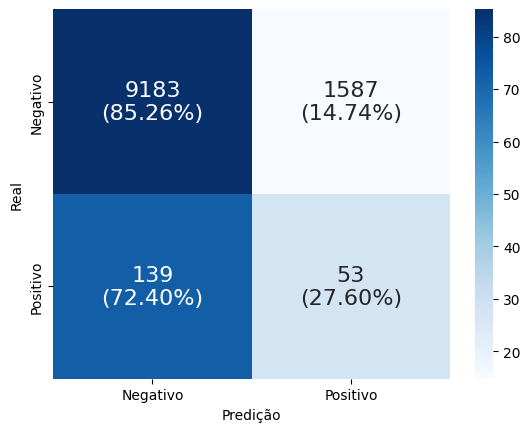

In [16]:
# Plot da matriz de confusão para a predição de cancer no nível imagem.
cm = confusion_matrix(test_features["y_label"].values, test_features["y_pred"].values)
cm_pct = confusion_matrix(test_features["y_label"].values, test_features["y_pred"].values, normalize = "true")

class_names = ['Negativo', 'Positivo']

ax = sns.heatmap(cm_pct*100, annot = True, fmt = '.2f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Impressão na matriz confusão dos resultados em número de imagens e o respectivo percentual dentro da classe.
i=0
for t in ax.texts:
  t.set_text(str(cm.flatten()[i])+ "\n("+ t.get_text() + "%)")
  i = i+1

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

## Matriz Confusão - Paciente + Lateralidade

Text(50.722222222222214, 0.5, 'Real')

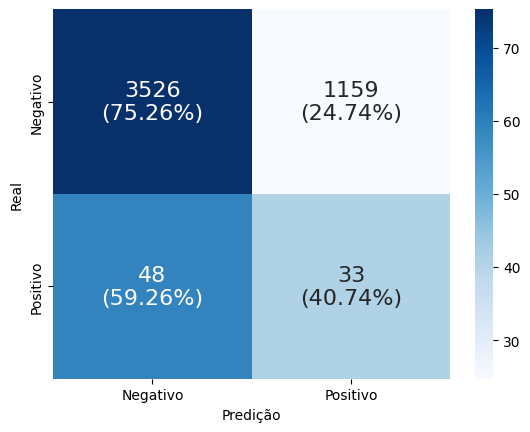

In [17]:
# Plot da matriz de confusão para a predição de cancer no nível paciente + lateralidade.
cm = confusion_matrix(test_features_patient["y_label"].values, test_features_patient["y_pred"].values)
cm_pct = confusion_matrix(test_features_patient["y_label"].values, test_features_patient["y_pred"].values, normalize = "true")

class_names = ['Negativo', 'Positivo']

ax = sns.heatmap(cm_pct*100, annot = True, fmt = '.2f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Impressão na matriz confusão dos resultados em número de pacientes + lateralidade e o respectivo percentual dentro da classe.
i=0
for t in ax.texts:
  t.set_text(str(cm.flatten()[i])+ "\n("+ t.get_text() + "%)")
  i = i+1

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

## Testes de parâmetros para a algoritmo de Random Forest

In [19]:
v_bal_acc = []

for i in range(2,18):
  print(i)
  model = RandomForestClassifier(max_depth=i).fit(train_features_smote[predictors], train_features_smote[target])
  v_bal_acc.append([i, balanced_accuracy_score(train_features_smote[target], model.predict(train_features_smote[predictors]))
  ,  balanced_accuracy_score(validation_features_smote[target], model.predict(validation_features_smote[predictors]))])

v_bal_acc

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


[[2, 0.6951309954795608, 0.6728690680585452],
 [3, 0.737048932389104, 0.6992864533834091],
 [4, 0.7674706486314085, 0.7136109174079142],
 [5, 0.8173021479018718, 0.7460996729543885],
 [6, 0.8581254429330867, 0.7659204441519902],
 [7, 0.8908106981069, 0.7796600109656711],
 [8, 0.9154431802553362, 0.7803849340906389],
 [9, 0.9361799464131699, 0.7863051953449539],
 [10, 0.9511276962241902, 0.7787902369766959],
 [11, 0.9649201101657449, 0.7793918747844298],
 [12, 0.9729121617672842, 0.7794623381611495],
 [13, 0.9806118870901759, 0.7664535499278577],
 [14, 0.9856378937525568, 0.761735663449715],
 [15, 0.9895681140786629, 0.7546174087739836],
 [16, 0.9912921512477354, 0.7530465566032134],
 [17, 0.9932207351995792, 0.7459854779245918]]

In [20]:
df_pos = pd.DataFrame(v_bal_acc, columns=["max_depth", "train_acc", "val_acc"])
df_pos

,max_depth,train_acc,val_acc
0,2,0.695131,0.672869
1,3,0.737049,0.699286
2,4,0.767471,0.713611
3,5,0.817302,0.746100
4,6,0.858125,0.765920
5,7,0.890811,0.779660
6,8,0.915443,0.780385
7,9,0.936180,0.786305
8,10,0.951128,0.778790
9,11,0.964920,0.779392


Text(0, 0.5, 'Bal. Acc.')

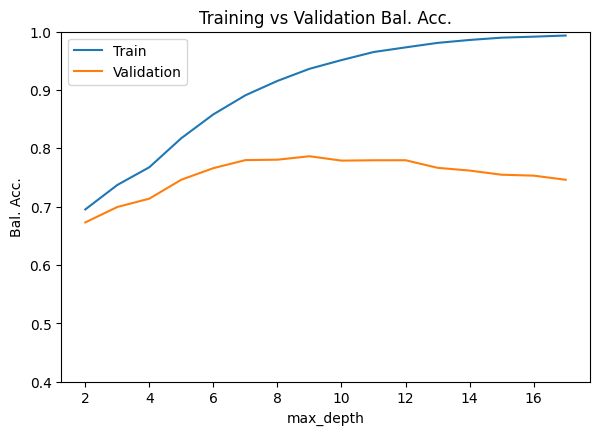

In [21]:
# Plot da acurácia balanceada durante treinamento e validação de acordo com a variação da profundidade máxima das árvores de decisão.
max_depth = df_pos['max_depth']
accuracy = df_pos['train_acc']
val_accuracy = df_pos['val_acc']

plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(max_depth, accuracy, label = "Training Bal. Acc.")
plt.plot(max_depth, val_accuracy, label = "Validation Bal. Acc.")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Bal. Acc.")
plt.xlabel('max_depth')
plt.ylabel('Bal. Acc.')

In [25]:
v_bal_acc = []

for i in [1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,75,100]:
  model = RandomForestClassifier(max_depth=9, n_estimators = i).fit(train_features_smote[predictors], train_features_smote[target])
  v_bal_acc.append([i, balanced_accuracy_score(train_features_smote[target], model.predict(train_features_smote[predictors]))
  ,  balanced_accuracy_score(validation_features_smote[target], model.predict(validation_features_smote[predictors]))])

In [26]:
df_pos = pd.DataFrame(v_bal_acc, columns=["n_estimators", "train_acc", "val_acc"])
df_pos

,n_estimators,train_acc,val_acc
0,1,0.731124,0.639529
1,2,0.828485,0.657088
2,3,0.851652,0.672638
3,4,0.856805,0.695918
4,5,0.869942,0.725468
5,6,0.882619,0.734359
6,7,0.886898,0.738446
7,8,0.885749,0.733770
8,9,0.900893,0.758833
9,10,0.899607,0.745813


Text(0, 0.5, 'Bal. Acc.')

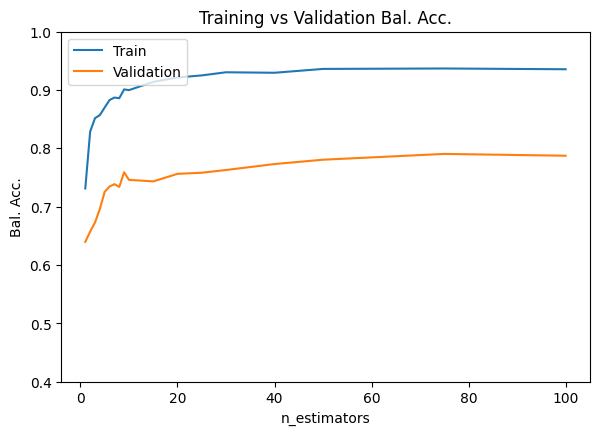

In [27]:
n_estimators = df_pos['n_estimators']
accuracy = df_pos['train_acc']
val_accuracy = df_pos['val_acc']

plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(n_estimators, accuracy, label = "Training Bal. Acc.")
plt.plot(n_estimators, val_accuracy, label = "Validation Bal. Acc.")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Bal. Acc.")
plt.xlabel('n_estimators')
plt.ylabel('Bal. Acc.')